# CS6140 Final Project Proposal: Walkability Index
### Team Members: James Fan, James Florez, Dominic Cauteruccio, Sara Spasojevic


## Step 0: Notebook Prep


In [2]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Set display options
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", 40)

# Set global random state
random_state = 1

## Step 1: Data Preprocessing and Analysis

#### Load Data

In [4]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

data_url = "https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv"
raw_df = pd.read_csv(data_url, sep=",", header=0)
raw_df.head()



,OBJECTID,GEOID10,GEOID20,STATEFP,COUNTYFP,TRACTCE,BLKGRPCE,CSA,CSA_Name,CBSA,CBSA_Name,CBSA_POP,CBSA_EMP,CBSA_WRK,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,...,D4E,D5AR,D5AE,D5BR,D5BE,D5CR,D5CRI,D5CE,D5CEI,D5DR,D5DRI,D5DE,D5DEI,D2A_Ranked,D2B_Ranked,D3B_Ranked,D4A_Ranked,NatWalkInd,Shape_Length,Shape_Area
0,1,4.811300e+11,4.811300e+11,48,113,7825,4,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,73.595028,0.0,73.595028,73.595028,1202,460.0,...,0.003602,433601,303660,135362,53504,0.000398,0.785893,0.000358,0.841299,0.000525,0.184697,0.000476,0.137707,6,14,15,17,14.000000,3110.360820,297836.0831
1,2,4.811300e+11,4.811300e+11,48,113,7825,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,119.829909,0.0,119.829909,119.214200,710,409.0,...,0.006099,386504,272135,236885,90089,0.000355,0.700531,0.000321,0.753958,0.000919,0.323221,0.000801,0.231868,3,10,12,14,10.833333,3519.469110,484945.1466
2,3,4.811300e+11,4.811300e+11,48,113,7825,3,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,26.367053,0.0,26.367053,26.367050,737,365.0,...,0.004071,404573,288925,230587,82815,0.000371,0.733281,0.000340,0.800475,0.000894,0.314628,0.000736,0.213146,1,1,7,17,8.333333,1697.091802,106705.9281
3,4,4.811300e+11,4.811300e+11,48,113,7824,1,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,119.060687,0.0,119.060687,119.060687,904,384.0,...,0.007378,423099,298058,168433,79657,0.000388,0.766859,0.000351,0.825778,0.000653,0.229821,0.000708,0.205018,16,10,17,17,15.666667,2922.609204,481828.4303
4,5,4.811300e+11,4.811300e+11,48,113,7824,2,206.0,"Dallas-Fort Worth, TX-OK",19100.0,"Dallas-Fort Worth-Arlington, TX",7189384,3545715,3364458,169.927211,0.0,169.927211,148.742920,948,343.0,...,0.007036,335700,238166,120826,48682,0.000308,0.608450,0.000281,0.659846,0.000469,0.164863,0.000433,0.125296,4,7,11,14,10.166667,3731.971773,687684.7752


After examining the description of each feature in the dataset's pdf, we have decided that we want to keep the following features. The goal of the project is to use the environmental and socioeconomic factors to predict the walkability score, and explore how those would affect it. In accordance with that, we have decided not to use the features already used to come up with the existing walkability score formula.

A lot of features were followed by the percentage representation of that feature in the area, which after some exploration, has shown to be the better approach (ie. auto own feature).

In [5]:
columns = ['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'Pct_AO0',\
           'Pct_AO1', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', \
           'R_HiWageWk', 'TotEmp', 'E5_Ret', 'E5_Off', 'E5_Ind', 'E5_Svc', 'E5_Ent', \
           'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
           'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', \
           'D5AE', 'D5BR', 'D5BE', 'NatWalkInd',]

df = raw_df[columns]
df.shape

(220740, 35)

#### Describe Data

In [6]:
# get column types
df.dtypes

Ac_Total       float64
Ac_Water       float64
Ac_Land        float64
Ac_Unpr        float64
TotPop           int64
CountHU        float64
HH             float64
P_WrkAge       float64
Pct_AO0        float64
Pct_AO1        float64
Pct_AO2p       float64
Workers          int64
R_LowWageWk      int64
R_MedWageWk      int64
R_HiWageWk       int64
TotEmp           int64
E5_Ret           int64
E5_Off           int64
E5_Ind           int64
E5_Svc           int64
E5_Ent           int64
E_LowWageWk      int64
E_MedWageWk      int64
E_HiWageWk       int64
D1A            float64
D1B            float64
D1C            float64
D1D            float64
D2C_TRPMX2     float64
D2R_WRKEMP     float64
D5AR             int64
D5AE             int64
D5BR             int64
D5BE             int64
NatWalkInd     float64
dtype: object

In [7]:
# describe numeric variables
df.describe()

,Ac_Total,Ac_Water,Ac_Land,Ac_Unpr,TotPop,CountHU,HH,P_WrkAge,Pct_AO0,Pct_AO1,Pct_AO2p,Workers,R_LowWageWk,R_MedWageWk,R_HiWageWk,TotEmp,E5_Ret,E5_Off,E5_Ind,E5_Svc,E5_Ent,E_LowWageWk,E_MedWageWk,E_HiWageWk,D1A,D1B,D1C,D1D,D2C_TRPMX2,D2R_WRKEMP,D5AR,D5AE,D5BR,D5BE,NatWalkInd
count,2.207400e+05,2.207400e+05,2.207400e+05,2.207400e+05,220740.000000,220465.000000,220465.000000,220740.00000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220469.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,2.207400e+05,220740.000000,2.207400e+05,2.207400e+05,220740.000000
mean,1.103567e+04,7.807248e+02,1.025494e+04,6.831866e+03,1479.863804,626.014628,548.785989,0.59474,0.092874,0.328227,0.569939,637.816753,146.015815,210.235820,281.565117,639.106487,71.185426,87.631625,151.342099,256.042117,72.905219,146.436255,211.019806,281.650426,4.530262,10.428739,3.773612,8.298313,0.491936,0.425024,1.030618e+05,88536.521695,4.413897e+04,1.520207e+02,9.541628
std,1.588982e+05,2.683978e+04,1.488759e+05,4.367872e+04,987.862242,383.714541,339.039272,0.10610,0.136020,0.151983,0.219775,420.866297,90.312972,135.076957,235.370220,2021.360339,227.948218,683.346046,638.944327,992.979149,358.621166,357.650538,550.314594,1273.883797,13.881912,29.129998,46.392440,50.474119,0.234264,0.306272,1.531004e+05,130263.329763,3.854568e+05,2.038590e+05,4.373952
min,1.096136e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-9.999900e+04,-9.999900e+04,1.000000
25%,1.231824e+02,0.000000e+00,1.200676e+02,1.143877e+02,889.000000,392.000000,341.000000,0.54400,0.010381,0.217391,0.432056,384.000000,91.000000,127.000000,136.000000,69.000000,0.000000,0.000000,5.000000,17.000000,0.000000,19.000000,25.000000,17.000000,0.300543,0.714507,0.075862,0.531225,0.326433,0.153326,9.260000e+03,9150.000000,-9.999900e+04,-9.999900e+04,5.833333
50%,3.394946e+02,0.000000e+00,3.229443e+02,3.044386e+02,1265.000000,544.000000,476.000000,0.59500,0.044010,0.319574,0.603448,550.000000,128.000000,183.000000,226.000000,200.000000,11.000000,7.000000,24.000000,63.000000,11.000000,54.000000,72.000000,59.000000,1.845611,4.320753,0.533630,3.140893,0.509930,0.389110,4.273400e+04,38964.000000,-9.999900e+04,-9.999900e+04,9.166667
75%,2.325991e+03,1.973606e+01,2.141221e+03,1.950541e+03,1816.000000,764.000000,673.000000,0.64800,0.115529,0.429613,0.737535,792.000000,181.000000,263.000000,362.000000,548.000000,51.000000,34.000000,86.000000,195.000000,60.000000,145.000000,198.000000,181.000000,4.163989,10.136846,2.157909,6.834936,0.685096,0.684399,1.251635e+05,105586.000000,4.775125e+04,3.174650e+04,13.166667
max,4.055649e+07,5.455459e+06,3.914039e+07,5.074313e+06,55407.000000,26436.000000,21337.000000,1.00000,1.000000,1.000000,1.000000,19255.000000,3639.000000,5014.000000,10683.000000,266101.000000,30444.000000,110844.000000,47840.000000,137775.000000,92976.000000,38083.000000,49946.000000,204309.000000,1481.257220,3133.578265,14032.760640,14111.660620,0.991059,1.000000,1.220602e+06,964355.000000,6.963967e+06,2.697797e+06,20.000000


In [8]:
# show null values
print(df.isnull().sum().sort_values(ascending=False))

CountHU        275
HH             275
D1A            271
Ac_Total         0
D1D              0
E_LowWageWk      0
E_MedWageWk      0
E_HiWageWk       0
D1B              0
D1C              0
D2C_TRPMX2       0
E5_Svc           0
D2R_WRKEMP       0
D5AR             0
D5AE             0
D5BR             0
D5BE             0
E5_Ent           0
E5_Off           0
E5_Ind           0
Ac_Water         0
E5_Ret           0
TotEmp           0
R_HiWageWk       0
R_MedWageWk      0
R_LowWageWk      0
Workers          0
Pct_AO2p         0
Pct_AO1          0
Pct_AO0          0
P_WrkAge         0
TotPop           0
Ac_Unpr          0
Ac_Land          0
NatWalkInd       0
dtype: int64


In [9]:
# Drop household NaN samples
df = df.dropna(subset=['CountHU'], axis=0)
df = df.dropna(subset=['HH'], axis=0)

# fill the leftover null variables with median
df = df.fillna(df.median())

df.shape


(220465, 35)

# EDA - Univariate Analysis

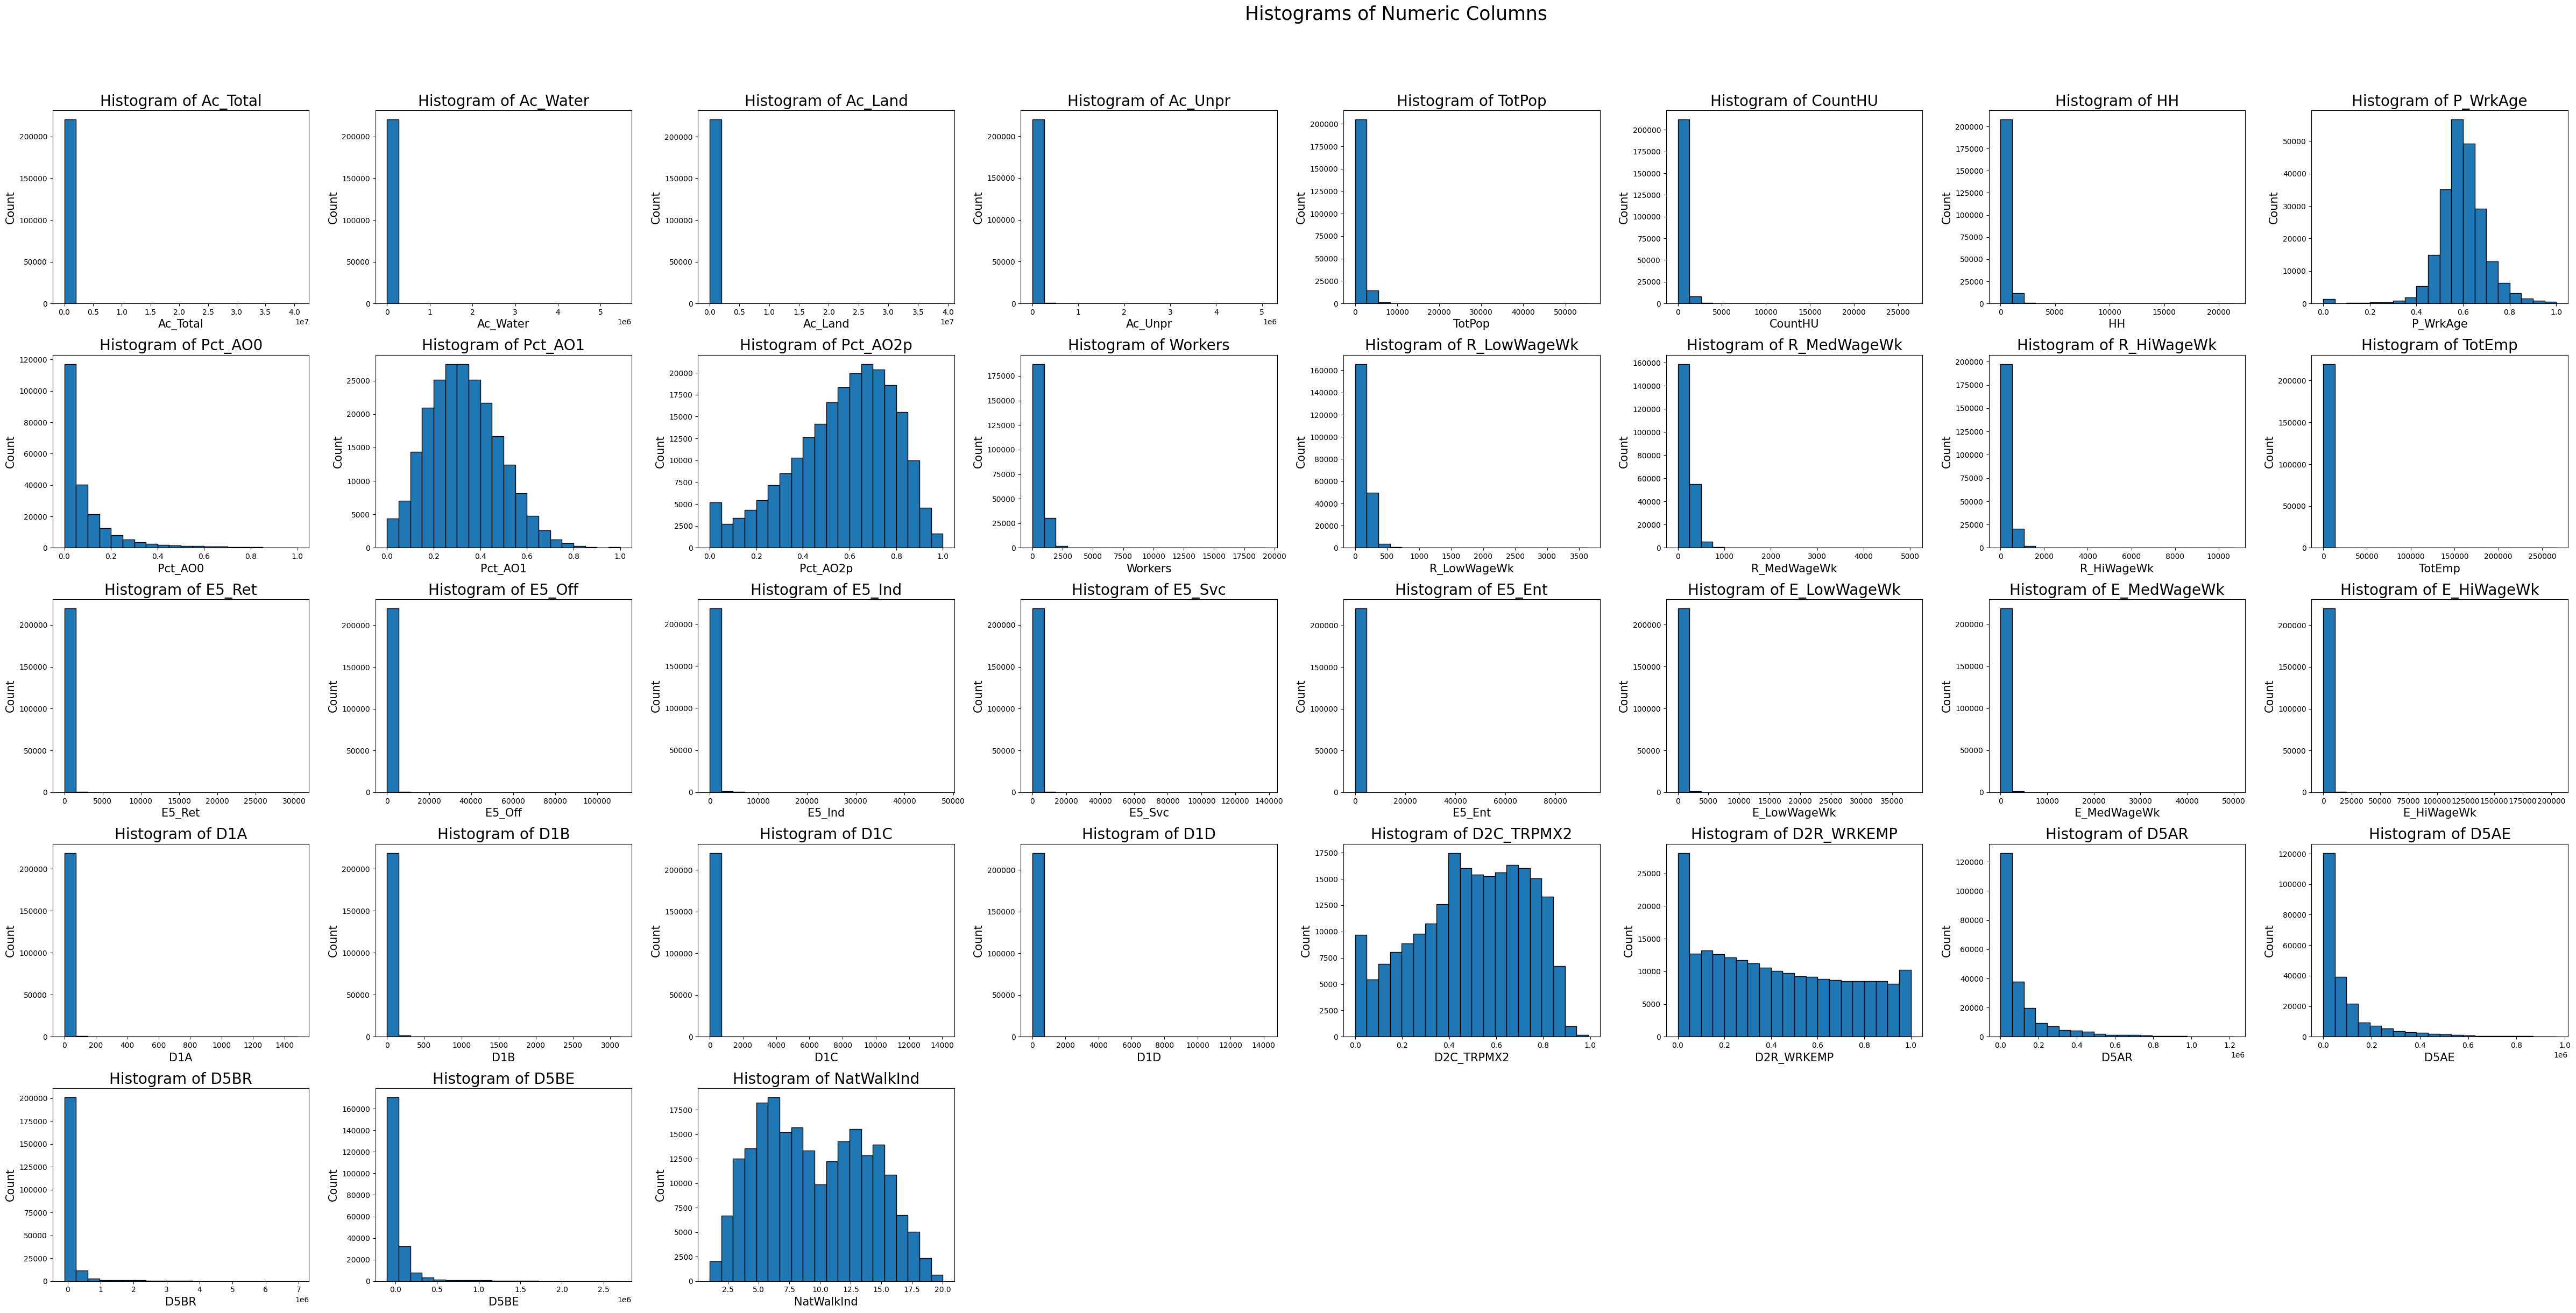

In [10]:
# Univariate Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for selected numeric columns with larger individual plots
plt.figure(figsize=(40, 30))
for i, column in enumerate(df.columns):
    plt.subplot(8, 8, i + 1)
    df[column].hist(bins=20, edgecolor='black', linewidth=1.0, grid=False)
    plt.title(f'Histogram of {column}', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Count', fontsize=15)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Histograms of Numeric Columns', x=0.65, y=1.25, fontsize=25)
plt.show()


Let's take a look at the correlation matrix.

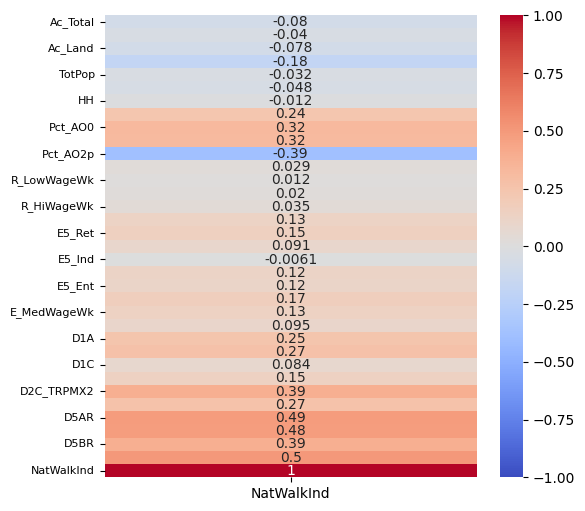

In [11]:
correlation_matrix = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[['NatWalkInd']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(fontsize=8)
plt.show()

## Head count per acre

We decided to create a feature that will show the head count per acre.

In [12]:
df[["TotPop", "Ac_Total", "NatWalkInd"]].corr()

,TotPop,Ac_Total,NatWalkInd
TotPop,1.000000,-0.020725,-0.031859
Ac_Total,-0.020725,1.000000,-0.080179
NatWalkInd,-0.031859,-0.080179,1.000000


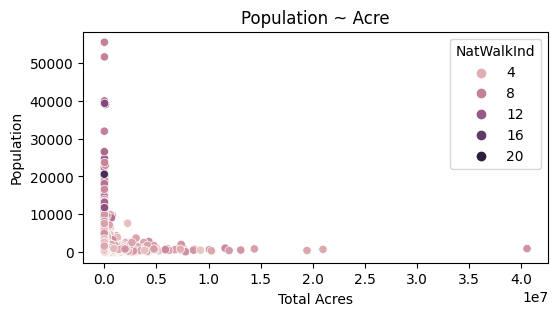

In [13]:
df['Pop_Acre'] = df['TotPop'] / df['Ac_Total']

plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Ac_Total", y="TotPop", hue="NatWalkInd")
plt.title('Population ~ Acre')
plt.xlabel('Total Acres')
plt.ylabel('Population')
plt.show()

After the feature was created, see below impact in the correlation map. It performs much higher than the TotPop.

In [14]:
df[["Pop_Acre", "NatWalkInd"]].corr()

,Pop_Acre,NatWalkInd
Pop_Acre,1.000000,0.307833
NatWalkInd,0.307833,1.000000


## Auto

Looking at the correlation heatmap and the way auto affects the walkability score, we decided to consolidate them to 1 or none, and 2 or more cars, to see how it would affect the score.

In [15]:
df[["Pct_AO0", "Pct_AO1", "Pct_AO2p", "NatWalkInd"]].corr()

,Pct_AO0,Pct_AO1,Pct_AO2p,NatWalkInd
Pct_AO0,1.000000,0.128376,-0.686125,0.322431
Pct_AO1,0.128376,1.000000,-0.695753,0.319058
Pct_AO2p,-0.686125,-0.695753,1.000000,-0.386020
NatWalkInd,0.322431,0.319058,-0.386020,1.000000


In [16]:
df['Pct_A_OneNone'] = df['Pct_AO0'] + df['Pct_AO1']

df.drop(['Pct_AO0', 'Pct_AO1'], axis=1, inplace=True)

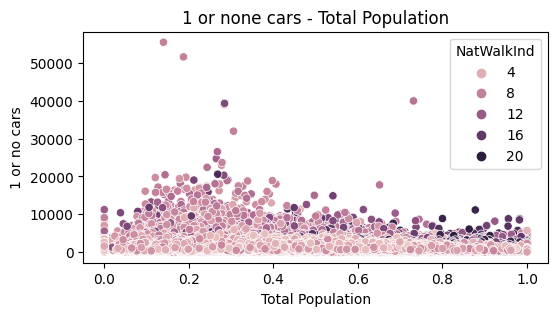

In [17]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Pct_A_OneNone", y="TotPop", hue="NatWalkInd")
plt.title('1 or none cars - Total Population')
plt.xlabel('Total Population')
plt.ylabel('1 or no cars')
plt.show()

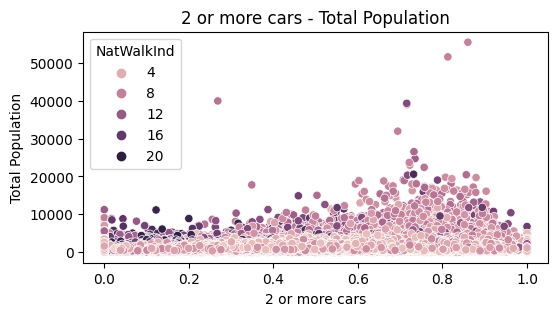

In [18]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Pct_AO2p", y="TotPop", hue="NatWalkInd")
plt.title('2 or more cars - Total Population')
plt.xlabel('2 or more cars')
plt.ylabel('Total Population')
plt.show()

Let's look at the correlation scores after this feature was created.

In [19]:
df[["Pct_A_OneNone", "Pct_AO2p", "NatWalkInd"]].corr()

,Pct_A_OneNone,Pct_AO2p,NatWalkInd
Pct_A_OneNone,1.000000,-0.91918,0.426415
Pct_AO2p,-0.919180,1.00000,-0.386020
NatWalkInd,0.426415,-0.38602,1.000000


## Household

Observe that we have features CountHU and HH, which are total number of households in that sector, and number of households occupied, respectively.
We chose to create one variable "Occupied" that will show the percentage of the occupied households.

In [20]:
df['Occupied'] = df.apply(lambda row: (row['HH'] / row['CountHU']) * 100 if row['CountHU'] != 0 else 100, axis=1)
df.drop(["CountHU", "HH"], axis=1, inplace=True)

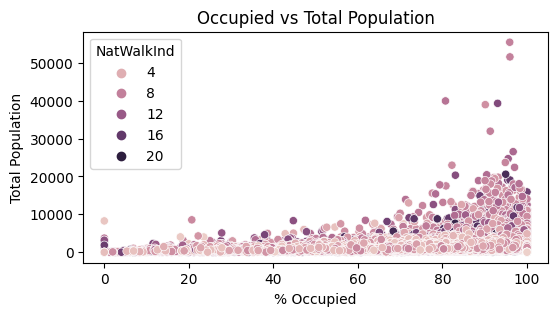

In [21]:
plt.figure(figsize=(6, 3))
sns.scatterplot(df, x="Occupied", y="TotPop", hue="NatWalkInd")
plt.title('Occupied vs Total Population')
plt.xlabel('% Occupied')
plt.ylabel('Total Population')
plt.show()

## Wage - residents

In [22]:
df['Pct_HighWage_Reside'] = df.apply(lambda row: ((row['R_HiWageWk'])/ row['Workers']) * 100 if row['Workers'] != 0 else 0, axis=1)
df.drop(['R_LowWageWk', 'R_MedWageWk', 'R_HiWageWk', 'Workers'], axis=1, inplace=True)

Let's see if there's a relationship between walkability and percentage of population that earns a high wage in areas that are labeled unwalkable (> 15).

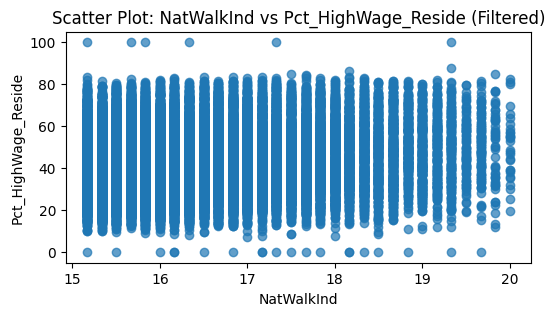

In [23]:
unwalkable = df[df['NatWalkInd'] > 15]

plt.figure(figsize=(6, 3))
plt.scatter(unwalkable['NatWalkInd'], unwalkable['Pct_HighWage_Reside'], alpha=0.7)
plt.title('Scatter Plot: NatWalkInd vs Pct_HighWage_Reside (Filtered)')
plt.xlabel('NatWalkInd')
plt.ylabel('Pct_HighWage_Reside')
plt.show()

From the graph we cannot observe any particular relationship, and seems like with only very high unwalkable scores (19, 20) increase the percentage of population with higher income.

See the correlation with walkability index below:

In [24]:
df[["Pct_HighWage_Reside", "NatWalkInd"]].corr()

,Pct_HighWage_Reside,NatWalkInd
Pct_HighWage_Reside,1.000000,0.112913
NatWalkInd,0.112913,1.000000


## E5

Taking a look at types of jobs in the area, and correlation map, we've decided to drop the Industrial, as they don't have a high predicting contribution. The highest seems to be retail, service and entertainment.

In [25]:
df['Pct_Retail'] = df.apply(lambda row: ((row['E5_Ret'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df['Pct_Service'] = df.apply(lambda row: ((row['E5_Svc'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df['Pct_Ent'] = df.apply(lambda row: ((row['E5_Ent'])/ row['TotEmp']) * 100 if row['TotEmp'] != 0 else 0, axis=1)

df.drop(['E5_Ret', 'E5_Off', 'E5_Ind','E5_Svc', 'E5_Ent'], axis=1, inplace=True)

Let's take a look at the correlation matrix after all the new features were made.

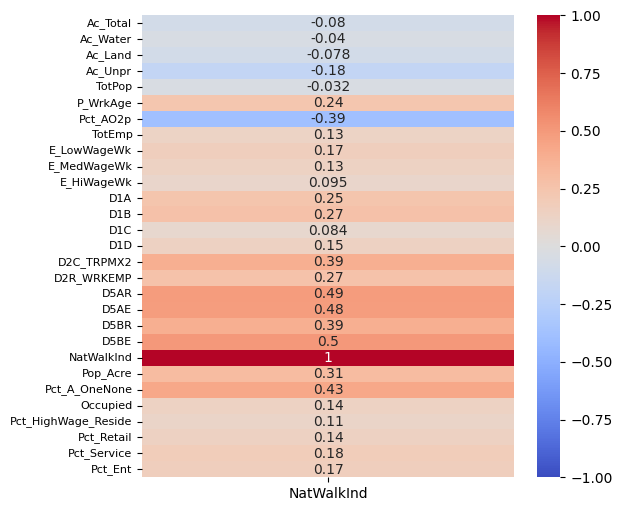

In [26]:
correlation_matrix = df.corr()
plt.figure(figsize=(6,6))
sns.heatmap(correlation_matrix[['NatWalkInd']], annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.yticks(fontsize=8)
plt.show()

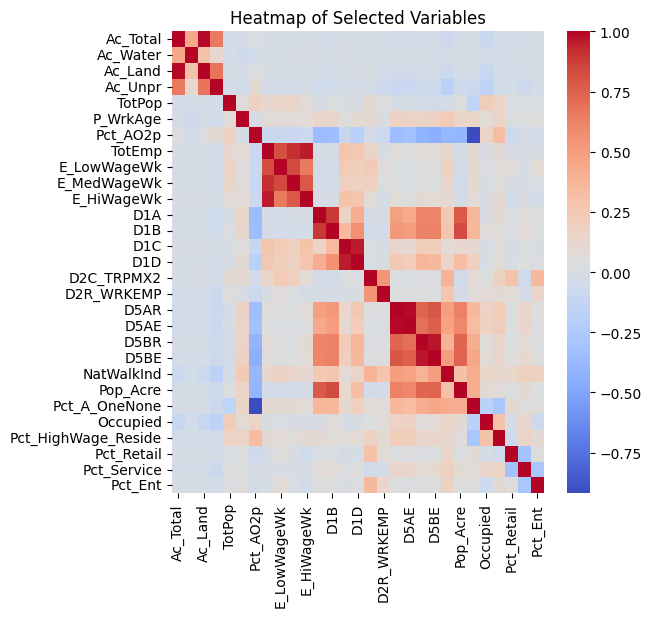

In [27]:
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, cmap='coolwarm', fmt='.2f')
plt.title('Heatmap of Selected Variables')
plt.show()

## Step 2: Model Creation

#### Split and Standardize the Dataset

In [28]:
# Function that splits dataset - K-fold
def create_splits(X, y):
    X_train_splits = []
    X_test_splits = []
    y_train_splits = []
    y_test_splits = []

    kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=random_state)

    for train_index, test_index in kf.split(X):
        # set new train/test groups
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # append to lists for use later
        X_train_splits.append(X_train)
        X_test_splits.append(X_test)
        y_train_splits.append(y_train)
        y_test_splits.append(y_test)

    return X_train_splits, X_test_splits, y_train_splits, y_test_splits

In [29]:
# Split data into X and Y
y = df["NatWalkInd"]
X = df.drop("NatWalkInd", axis=1)

#### Define Hyperparameters and Initialize Models

In [177]:
# Linear Regression
linear = linear_model.LinearRegression()

# Ridge Regression
ridge_alpha = 1.1 # Regularization param, default is 1.0 for full penalty
ridge = linear_model.Ridge(alpha=ridge_alpha)

# Random Forest
rf_estimators = 10
rf_max_depth = None  # You can adjust the max depth for regularization
rf_min_samples_leaf = 10
rf_max_features = 10
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, max_depth=None, random_state=random_state, 
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)


# Support Vector Machine (SVM)
svm_kernel = "rbf"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 1.0  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 1000 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

# Multi-Layer Perceptron (MLP)
mlp_num_layers = 5
mlp_num_neurons = 5
mlp_alpha = 0.0001 # Regularization param
mlp_learning_rate_init = 0.001
mlp_max_iter = 1000
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    learning_rate_init=mlp_learning_rate_init,
    max_iter=mlp_max_iter,
    random_state=random_state)

## Step 3: Model Training and Evaluation

In [143]:
# Define a function to train and evaluate a regression model

def model_train_and_eval_single(model, X_train, X_test, y_train, y_test, columns, model_name, visual, reg_param):
  # Given a regression model and data, this trains the model, plots the coefficients, and evaluates the performance.

  # Train the model with training data
    if reg_param:
        if model_name == "Ridge":
            model.set_params(alpha=reg_param)
        elif model_name == "RandomForestRegressor":
            model.set_params(max_depth=reg_param)
            # Adjust regularization parameters for RandomForest if needed
        elif model_name == "SVM":
            model.set_params(C=reg_param)
        elif model_name == "MLPRegressor":
            model.set_params(alpha=reg_param)

    # Train the model with training data
    model.fit(X_train, y_train)

    # Make predicitions on test data
    y_pred = model.predict(X_test)

    # Plot the weights of the model
    if (model_name in ["Linear", "Ridge"]) and visual:
      plt.plot(columns, model.coef_)
      plt.title(f"Coefficients of {model_name} Regression Model")
      plt.xticks(rotation=90)
      plt.grid()
      plt.show()

    # Evaluate performance of the model
    mse = metrics.mean_squared_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse}")
    print(f"R-squared: {r2}")

    return mse, r2


# Initialize variable to hold MSE and R^2 results
mse_list = []
r2_list = []

In [144]:
def model_train_and_eval(model, X, y, k_fold=True, standardization=True, model_name=None, visual = False, reg_param=None):
    columns = X.columns
    if k_fold:
        kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=42)
        mse_list = []
        r2_list = []

        for train_index, test_index in kf.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            if standardization:
                scaler = preprocessing.StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)

            mse, r2 = model_train_and_eval_single(model, X_train, X_test, y_train, y_test, columns, model_name, visual, reg_param)
            mse_list.append(mse)
            r2_list.append(r2)

        return mse_list, r2_list

    else:
        if standardization:
            scaler = preprocessing.StandardScaler()
            X = scaler.fit_transform(X)

        # Use an 80-20 train-test split
        X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

        return model_train_and_eval_single(model, X_train, X_test, y_train, y_test, columns, model_name, visual, reg_param)

#### Linear Regression

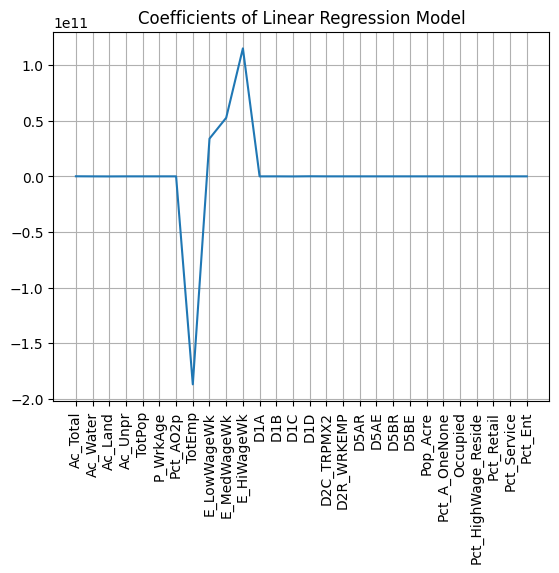

Mean Squared Error: 7.26149941431891
R-squared: 0.6181618535788431


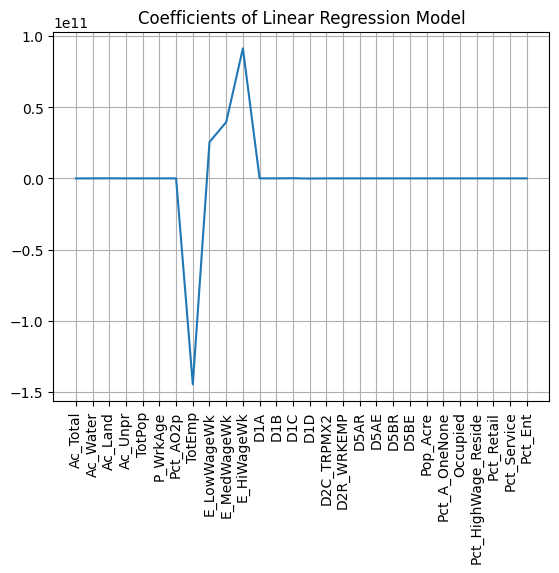

Mean Squared Error: 7.360824530397647
R-squared: 0.6169014250297598


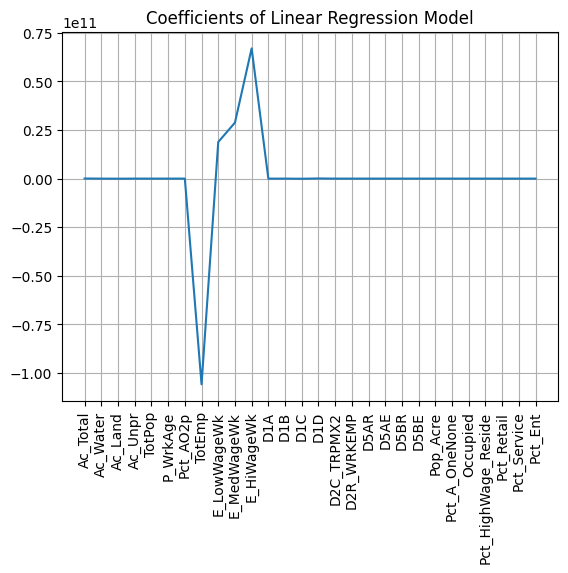

Mean Squared Error: 7.301109300199209
R-squared: 0.6131237949492645


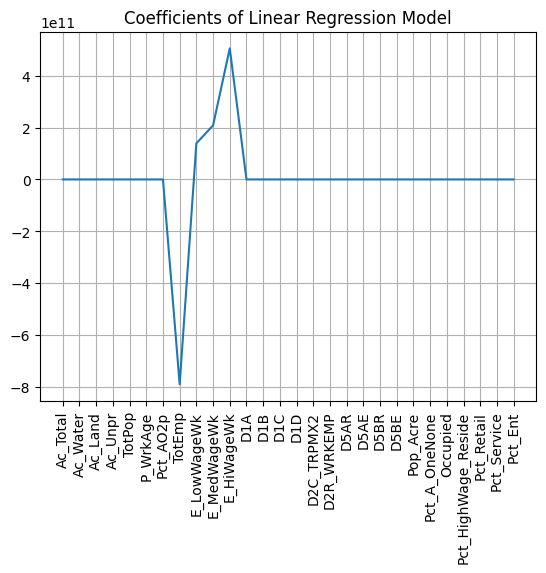

Mean Squared Error: 7.349924625895048
R-squared: 0.618015909758733


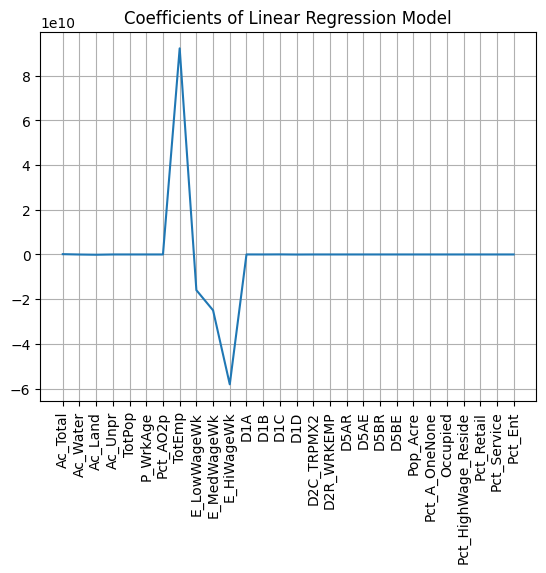

Mean Squared Error: 7.340549905962689
R-squared: 0.6131556623557938

Mean MSE: 7.3227815553547
Mean R-squared: 0.6158717291344789


In [58]:
linear_mse_list, linear_r2_list = model_train_and_eval(linear, X, y, model_name="Linear", visual=True, reg_param=None)

mse_list.append(np.mean(linear_mse_list))
r2_list.append(np.mean(linear_r2_list))

print(f"\nMean MSE: {np.mean(linear_mse_list)}")
print(f"Mean R-squared: {np.mean(linear_r2_list)}")

#### Ridge Regression

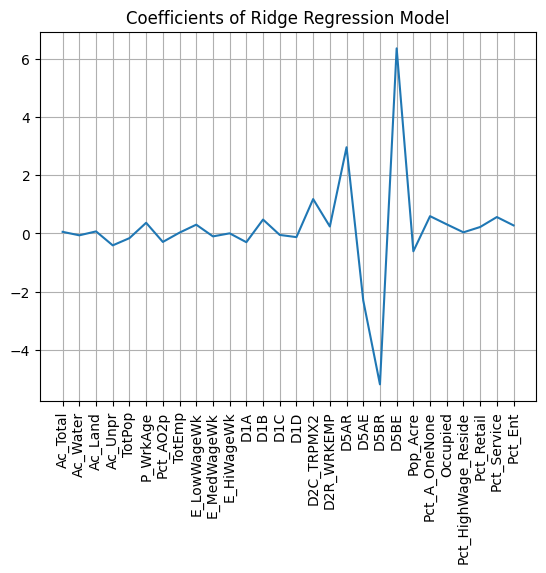

Mean Squared Error: 7.260700749321842
R-squared: 0.6182038505197904


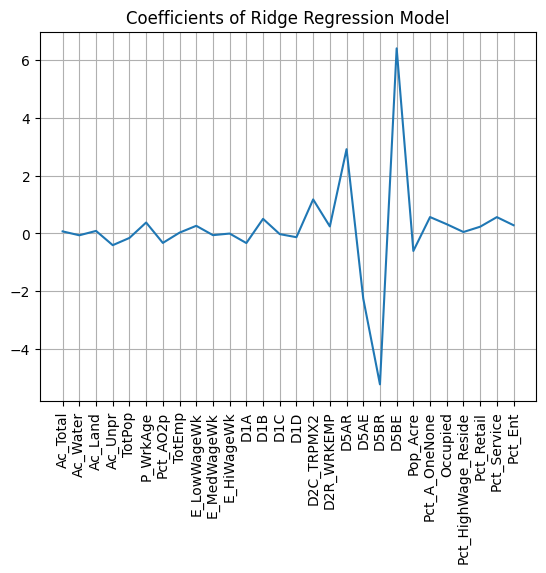

Mean Squared Error: 7.34241751314317
R-squared: 0.6178594294014876


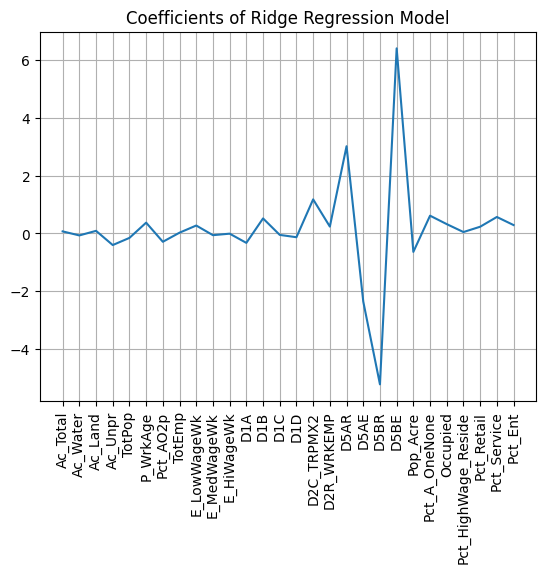

Mean Squared Error: 7.300091989327185
R-squared: 0.6131777009179801


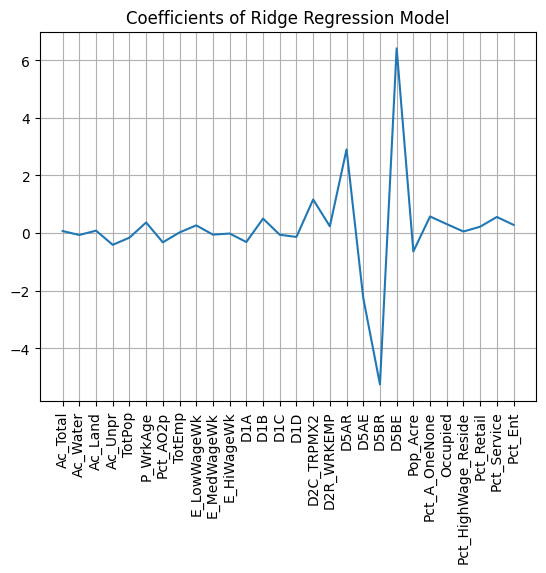

Mean Squared Error: 7.349783092186325
R-squared: 0.6180232654293987


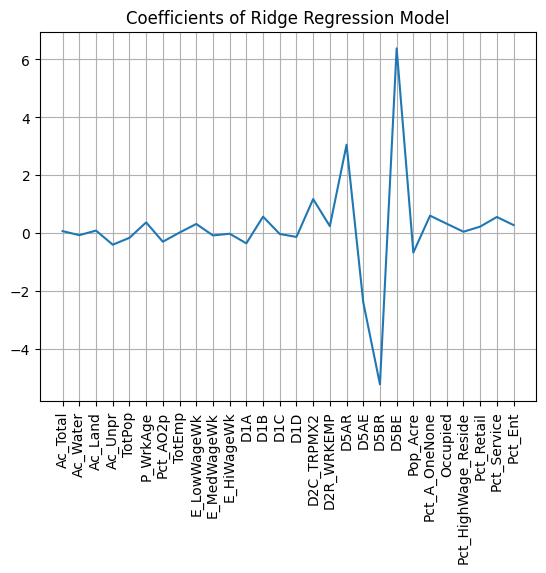

Mean Squared Error: 7.335780346643379
R-squared: 0.6134070164150087

Mean MSE: 7.31775473812438
Mean R-squared: 0.6161342525367332


In [59]:
ridge_mse_list, ridge_r2_list = model_train_and_eval(ridge, X, y, model_name="Ridge", visual=True, reg_param=1)

mse_list.append(np.mean(ridge_mse_list))
r2_list.append(np.mean(ridge_r2_list))

print(f"\nMean MSE: {np.mean(ridge_mse_list)}")
print(f"Mean R-squared: {np.mean(ridge_r2_list)}")

#### Random Forest

In [150]:
rf_mse_list, rf_r2_list = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

mse_list.append(np.mean(rf_mse_list))
r2_list.append(np.mean(rf_r2_list))

print(f"\nMean MSE: {np.mean(rf_mse_list)}")
print(f"Mean R-squared: {np.mean(rf_r2_list)}")

Mean Squared Error: 1.2967293694464246
R-squared: 0.9318128790504434
Mean Squared Error: 1.2844590970363183
R-squared: 0.933149547628791
Mean Squared Error: 1.2886262015059158
R-squared: 0.9317173878558495
Mean Squared Error: 1.2969831388828834
R-squared: 0.9325942850326701
Mean Squared Error: 1.305628232153706
R-squared: 0.9311938621564568

Mean MSE: 1.29448520780505
Mean R-squared: 0.9320935923448422


#### Support Vector Machine

In [178]:
svm_mse_list, svm_r2_list = model_train_and_eval(svm_model, X, y, model_name="SVM", reg_param=svm_c)

mse_list.append(np.mean(svm_mse_list))
r2_list.append(np.mean(svm_r2_list))

print(f"\nMean MSE: {np.mean(svm_mse_list)}")
print(f"Mean R-squared: {np.mean(svm_r2_list)}")

/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.8355414892863315
R-squared: 0.6931443193069724


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 2.5234822909765273
R-squared: 0.8686638343784131


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 2.5353597628601094
R-squared: 0.8656546117633264


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.123026179843283
R-squared: 0.7337503996034077


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 6.162140494677817
R-squared: 0.6752574141348944

Mean MSE: 4.435910043528813
Mean R-squared: 0.7672941158374028


#### Multi-Layer Perceptron

In [37]:
mlp_mse_list, mlp_r2_list = model_train_and_eval(mlp, X, y, model_name="MLP", reg_param=mlp_alpha)

mse_list.append(np.mean(mlp_mse_list))
r2_list.append(np.mean(mlp_r2_list))

Mean Squared Error: 1.504074312498366
R-squared: 0.9209098679493705
Mean Squared Error: 1.4732605226636848
R-squared: 0.9233232629766439
Mean Squared Error: 1.5066599102505052
R-squared: 0.9201640676213554
Mean Squared Error: 1.5078345050417958
R-squared: 0.9216360954759257
Mean Squared Error: 1.5328197507792174
R-squared: 0.9192209509077129


#### Plot Performance of Different Models

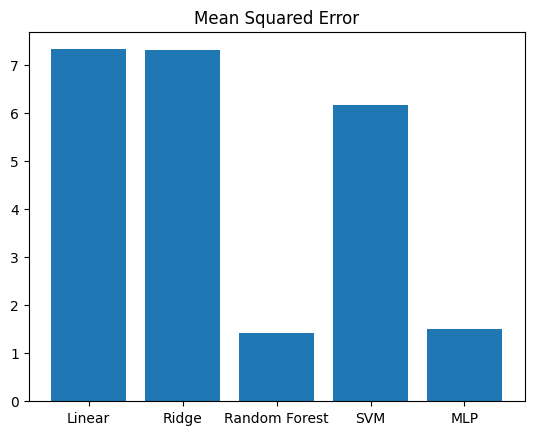

In [38]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], mse_list)
plt.title("Mean Squared Error")
plt.show()

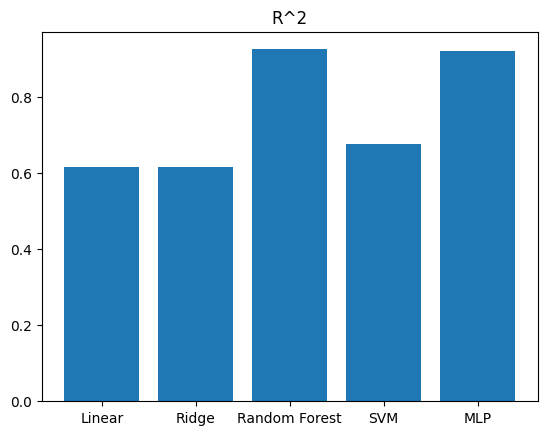

In [39]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], r2_list)
plt.title("R^2")
plt.show()

# Ablation Studies

## Linear Regression

There is not that much to take away with linear regression given that it's a pretty simple model. The ablation studies done here will show how taking away different features affect the model.


#### Baseline:
Mean MSE: 7.3227815553547

Mean R-squared: 0.6158717291344789

### Engineered features

Let's take away the engineered features to show how this will affect the score.

In [40]:
features = df.columns.tolist()
print(features)

['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'P_WrkAge', 'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', 'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', 'D5AE', 'D5BR', 'D5BE', 'NatWalkInd', 'Pop_Acre', 'Pct_A_OneNone', 'Occupied', 'Pct_HighWage_Reside', 'Pct_Retail', 'Pct_Service', 'Pct_Ent']


In [56]:
df_no_eng = df[['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'P_WrkAge', \
                'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
                'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', 'D5AE', \
                'D5BR', 'D5BE', 'NatWalkInd']]

y_no_eng = df_no_eng['NatWalkInd']
X_no_eng = df_no_eng.drop("NatWalkInd", axis=1)

linear_mse_no_eng, linear_r2_no_eng = model_train_and_eval(linear, X_no_eng, y_no_eng, model_name="Linear")

print(f"\nMean MSE: {np.mean(linear_mse_no_eng)}")
print(f"Mean R-squared: {np.mean(linear_r2_no_eng)}")

Mean Squared Error: 7.727611486970579
R-squared: 0.5936518509346398
Mean Squared Error: 7.831898222744274
R-squared: 0.5923841091368603
Mean Squared Error: 7.730204370297787
R-squared: 0.5903866100229702
Mean Squared Error: 7.8085397575135485
R-squared: 0.5941811505280098
Mean Squared Error: 7.775760969949566
R-squared: 0.590220195947933

Mean MSE: 7.77480296149515
Mean R-squared: 0.5921647833140826


As expected, you can see how taking away these features lowers the score.

### Environmental Factors

Given that our project's goal is to explore environmental and socioeconomical factors' effect on ealkability score, let's try taking away the environmental factors.

In [55]:
df_no_env = df[['TotPop', 'P_WrkAge', 'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', \
                'E_HiWageWk', 'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', \
                'D5AR', 'D5AE', 'D5BR', 'D5BE', 'NatWalkInd', 'Pop_Acre', 'Pct_A_OneNone', \
                'Occupied', 'Pct_HighWage_Reside', 'Pct_Retail', 'Pct_Service', 'Pct_Ent']]

y_no_env = df_no_env['NatWalkInd']
X_no_env = df_no_env.drop("NatWalkInd", axis=1)

linear_mse_no_env, linear_r2_no_env = model_train_and_eval(linear, X_no_env, y_no_env, model_name="Linear")

print(f"\nMean MSE: {np.mean(linear_mse_no_env)}")
print(f"Mean R-squared: {np.mean(linear_r2_no_env)}")

Mean Squared Error: 7.327188140556783
R-squared: 0.6147076824722565
Mean Squared Error: 7.455961620470543
R-squared: 0.6119499575028233
Mean Squared Error: 7.412187462495997
R-squared: 0.6072379088288884
Mean Squared Error: 7.467108133316522
R-squared: 0.6119257472397913
Mean Squared Error: 7.463350209899096
R-squared: 0.6066841305431433

Mean MSE: 7.425159113347787
Mean R-squared: 0.6105010853173807


It is interesting to see that removing the basic features like size of land of the sector, amount of unprotected land and water, does not affect the score significantly. Some of the features we left in this ablation steps have to do with the amount of jobs/people within specific distance, and as these are not solely environmental factors, we've decided to keep them in.

### Socioeconomic factors

This is the big step as it will show the importance of these features in our model. We chose to remove everything that has to do with wages, social status, and keep only the environmental features.

In [115]:
df_no_soc = df[['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'D5AR', 'D5AE', 'D5BR', 'D5BE', \
                 'NatWalkInd']]

y_no_soc = df_no_soc['NatWalkInd']
X_no_soc = df_no_soc.drop("NatWalkInd", axis=1)

linear_mse_no_soc, linear_r2_no_soc = model_train_and_eval(linear, X_no_soc, y_no_soc, model_name="Linear")

print(f"\nMean MSE: {np.mean(linear_mse_no_soc)}")
print(f"Mean R-squared: {np.mean(linear_r2_no_soc)}")

Mean Squared Error: 10.919490356567486
R-squared: 0.4258103292835559
Mean Squared Error: 11.016350617933849
R-squared: 0.42664735374761187
Mean Squared Error: 10.79887027364589
R-squared: 0.42778202893232553
Mean Squared Error: 11.043590856530443
R-squared: 0.4260518003863415
Mean Squared Error: 10.796788925321895
R-squared: 0.4310131101884128

Mean MSE: 10.915018205999914
Mean R-squared: 0.4274609245076495


As expected, the score drops significantly. This shows that environmental factors do have some predicting power, however, the importance lies in the socioeconomic ones.

Following, we have decided to explore Ridge Regression to see if the regularization factor would improve our scores.

## Ridge Regression

#### Baseline:

Mean MSE: 7.31775473812438

Mean R-squared: 0.6161342525367332

One thing we can ablate here is the level of regularization. As our alpha is set to 1, I will first set it to very close to 0 - very little regularization.

In [82]:
ridge_mse_lowr, ridge_r2_lowr = model_train_and_eval(ridge, X, y, model_name="Ridge", reg_param = 0.1)

print(f"\nMean MSE: {np.mean(ridge_mse_lowr)}")
print(f"Mean R-squared: {np.mean(ridge_r2_lowr)}")

Mean Squared Error: 7.2606761081135955
R-squared: 0.6182051462512566
Mean Squared Error: 7.342409509974767
R-squared: 0.6178598459312389
Mean Squared Error: 7.300104316539888
R-squared: 0.6131770477151484
Mean Squared Error: 7.349788651362764
R-squared: 0.6180229765125644
Mean Squared Error: 7.33581007342508
R-squared: 0.6134054498243139

Mean MSE: 7.317757731883219
Mean R-squared: 0.6161340932469045


As seen above, when regularization is dropped to 0.1, there is not much change in scores.

Let's see if the number is significantly increased:

In [98]:
ridge_mse_hir, ridge_r2_hir = model_train_and_eval(ridge, X, y, model_name="Ridge", reg_param = 100)

print(f"\nMean MSE: {np.mean(ridge_mse_hir)}")
print(f"Mean R-squared: {np.mean(ridge_r2_hir)}")

Mean Squared Error: 7.264661457601323
R-squared: 0.6179955809294948
Mean Squared Error: 7.3446116427716
R-squared: 0.6177452345948488
Mean Squared Error: 7.300206426721765
R-squared: 0.6131716370305473
Mean Squared Error: 7.3504843576382575
R-squared: 0.6179868198521569
Mean Squared Error: 7.334239556375598
R-squared: 0.6134882155074779

Mean MSE: 7.31884068822171
Mean R-squared: 0.6160774975829051


Not even making it overly high makes the number different. If the dataset is not very noisy or if there are not many highly correlated features, our model may not be that sensitive to changes in alpha. Ridge regression is more effective when dealing with multicollinearity. Generally, if the is already well-behaved, regularization may not have a substantial effect.

Let's explore taking features away with close-to-zero coefficients. Those are the following columns:

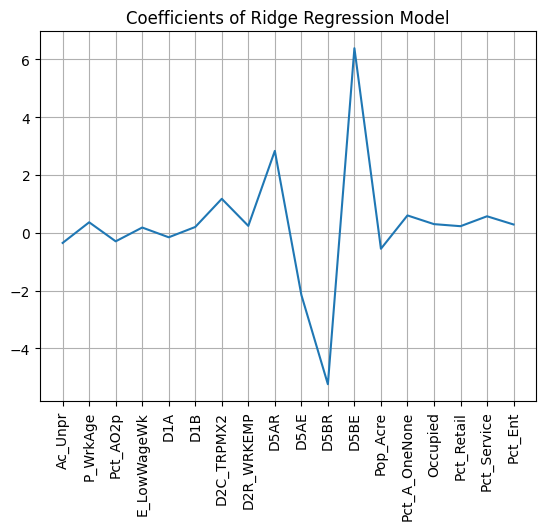

Mean Squared Error: 7.320687999832617
R-squared: 0.6150494853898052


In [113]:
df_higher_coeff = df[['Ac_Unpr', 'P_WrkAge', 'Pct_AO2p', 'E_LowWageWk', 'D1A', 'D1B', \
                      'D2C_TRPMX2', 'D2R_WRKEMP','D5AR', 'D5AE', 'D5BR', 'D5BE', \
                      'Pop_Acre', 'Pct_A_OneNone', 'Occupied', 'Pct_Retail', 'Pct_Service', \
                      'Pct_Ent', 'NatWalkInd']]

y_higher_coeff = df_higher_coeff['NatWalkInd']
X_higher_coeff = df_higher_coeff.drop("NatWalkInd", axis=1)

ridge_mse, ridge_r2 = model_train_and_eval(ridge, X_higher_coeff, y_higher_coeff, model_name="Ridge", 
                                           k_fold = False, visual=True)

Picking these features does increase the score but ever so slightly.

Following, let's explore how top 6 coefficient features perform. 

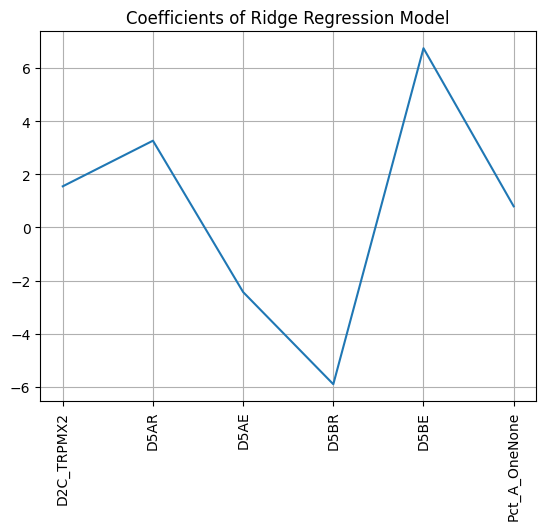

Mean Squared Error: 8.103057884727226
R-squared: 0.5739094054119963


In [116]:
df_topsix = df[['D2C_TRPMX2','D5AR', 'D5AE', 'D5BR', 'D5BE', \
                      'Pct_A_OneNone', 'NatWalkInd']]

y_topsix = df_topsix['NatWalkInd']
X_topsix = df_topsix.drop("NatWalkInd", axis=1)

ridge_mse, ridge_r2 = model_train_and_eval(ridge, X_topsix, y_topsix, model_name="Ridge", 
                                           k_fold = False, visual=True)

We can see how the score dropped when eliminating all those features, but it is very interesting to see that these 6 features carry most of the prediction power, which an also be seen from the graph above.

Because of the simplicity of linear regression models, we chose to move away from them and explore other ones. First one being random forest.

## Random Forest

#### Baseline:

Mean MSE: 1.29448520780505

Mean R-squared: 0.9320935923448422

Now that we have our baseline scores, let's explore how changes in our parameters affect them. There is no regularization that sets the depth of the tree (default in None), so I will show how setting the tree depth affects our scores.


In [152]:
rf_max_depth = 10  # You can adjust the max depth for regularization
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, max_depth=rf_max_depth, random_state=random_state, 
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)

rf_mse_shallow, rf_r2_shallow = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_shallow)}")
print(f"Mean R-squared: {np.mean(rf_r2_shallow)}")

Mean Squared Error: 1.408158826459818
R-squared: 0.9259534807505813
Mean Squared Error: 1.4183713788892942
R-squared: 0.9261800017393284
Mean Squared Error: 1.412504363429345
R-squared: 0.9251532465448449
Mean Squared Error: 1.4147515923120766
R-squared: 0.9264737221926405
Mean Squared Error: 1.4414196649316957
R-squared: 0.924037702530311

Mean MSE: 1.4190411652044461
Mean R-squared: 0.9255596307515411


Setting the tree depth to 10 levels did indeed drop the score, which indicates that regularization is too high. It overfits to the training set, and generalizing to unseen data drops in comparison to our baseline model.

Next step is dropping the number of trees to 1. This way, it would be the equivalent of using just one decision tree rather than a forest.

In [154]:
rf_estimators = 1
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, random_state=random_state, 
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)

rf_mse_single, rf_r2_single = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_single)}")
print(f"Mean R-squared: {np.mean(rf_r2_single)}")

Mean Squared Error: 1.883466833666256
R-squared: 0.9009599197660606
Mean Squared Error: 1.8661188696356026
R-squared: 0.9028767121495486
Mean Squared Error: 1.8642193637791018
R-squared: 0.9012174611847987
Mean Squared Error: 1.8846945661356638
R-squared: 0.9020502418907023
Mean Squared Error: 1.888060882529762
R-squared: 0.9004998711416875

Mean MSE: 1.8773121031492774
Mean R-squared: 0.9015208412265595


Dropping the number of trees shows how a single decision tree would perform. This definitely shows us the benifit of using a random forest.

Following, I will show how eliminating yet another component affects the model. Min_samples_leaf set to default (1) increases performance time, but the change in the score is not that significant.

In [156]:
random_forest = ensemble.RandomForestRegressor(n_estimators=10, random_state=random_state, max_features = 10)

rf_mse_minleaf, rf_r2_minleaf = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_minleaf)}")
print(f"Mean R-squared: {np.mean(rf_r2_minleaf)}")

Mean Squared Error: 1.357983122768643
R-squared: 0.9285919162305918
Mean Squared Error: 1.3314809445455718
R-squared: 0.9307022670695451
Mean Squared Error: 1.346705319068041
R-squared: 0.9286398515978294
Mean Squared Error: 1.3542949624357241
R-squared: 0.9296157232250061
Mean Squared Error: 1.367426292119912
R-squared: 0.927937126641873

Mean MSE: 1.3515781281875783
Mean R-squared: 0.9290973769529691


Finally, I will show one of the most important components when it comes to reducing time taken to compute - max_features. When left on default, the model considers all the features when looking for the best split and this makes one iteration go from approx. 10 seconds to about 40 seconds to compute. In addition, the score stays very similar to the one in the previous ablation step, and the benefit of having this parameter is evident. Time vs score tradeoff in this case is very much explained. We have seen max_features set to "sqrt" also perform similar to the current chosen one.

In [157]:
random_forest = ensemble.RandomForestRegressor(n_estimators=10, random_state=random_state)

rf_mse_maxf, rf_r2_maxf = model_train_and_eval(random_forest, X, y, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_maxf)}")
print(f"Mean R-squared: {np.mean(rf_r2_maxf)}")

Mean Squared Error: 1.3592438230106547
R-squared: 0.928525623662606
Mean Squared Error: 1.3387110856172826
R-squared: 0.9303259699944052
Mean Squared Error: 1.3501895896885143
R-squared: 0.9284552246679214
Mean Squared Error: 1.3604688574859638
R-squared: 0.9292948587530492
Mean Squared Error: 1.360457769784063
R-squared: 0.9283043652604921

Mean MSE: 1.3538142251172958
Mean R-squared: 0.9289812084676947


#### Feature ablation

We will use the above versions of datasets in these steps to show the feature importance.

##### Environmental Factors

Taking away environmental features.

In [158]:
# Use the best performing RF model
rf_estimators = 10
rf_max_depth = None  # You can adjust the max depth for regularization
rf_min_samples_leaf = 10
rf_max_features = 10
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, max_depth=rf_max_depth, random_state=random_state, 
                                               min_samples_leaf = rf_min_samples_leaf, max_features = rf_max_features)

In [159]:
rf_mse_no_env, rf_r2_no_env = model_train_and_eval(random_forest, X_no_env, y_no_env, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_no_env)}")
print(f"Mean R-squared: {np.mean(rf_r2_no_env)}")

Mean Squared Error: 1.322502071534278
R-squared: 0.9304576491961125
Mean Squared Error: 1.311009434506158
R-squared: 0.9317677192198036
Mean Squared Error: 1.3024935856196507
R-squared: 0.9309825733613237
Mean Squared Error: 1.3174922745037412
R-squared: 0.9315284015154205
Mean Squared Error: 1.334498756193394
R-squared: 0.9296723959321754

Mean MSE: 1.3175992244714443
Mean R-squared: 0.9308817478449672


When compared to our baseline R_squared of 0.932, this one is not too much behind - this brings us to conclude that simple environmental factors such as amount of water, land and unprotected land is not that crucial in predicting the walkability score. 

But a different story can be said about the combined environmental-socioeconomic factors. Let's take those away and see how the model performs:

In [160]:
df_no_env_soc = df[['TotPop', 'P_WrkAge', 'Pct_AO2p', 'TotEmp', 'E_LowWageWk', 'E_MedWageWk', \
                'E_HiWageWk', 'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', \
                'NatWalkInd', 'Pop_Acre', 'Pct_A_OneNone', \
                'Occupied', 'Pct_HighWage_Reside', 'Pct_Retail', 'Pct_Service', 'Pct_Ent']]

y_no_env_soc = df_no_env_soc['NatWalkInd']
X_no_env_soc = df_no_env_soc.drop("NatWalkInd", axis=1)

rf_mse_no_env_soc, rf_r2_no_env_soc = model_train_and_eval(random_forest, X_no_env_soc, y_no_env_soc, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_no_env_soc)}")
print(f"Mean R-squared: {np.mean(rf_r2_no_env_soc)}")

Mean Squared Error: 4.358125059741955
R-squared: 0.7708326752182841
Mean Squared Error: 4.318111793669934
R-squared: 0.7752612539688168
Mean Squared Error: 4.371670197626897
R-squared: 0.7683509304887209
Mean Squared Error: 4.362229762950587
R-squared: 0.7732898700003823
Mean Squared Error: 4.377109625313092
R-squared: 0.769327898387436

Mean MSE: 4.357449287860494
Mean R-squared: 0.771412525612728


This shows the importance of features D5ar, D5ae, D5br, D5be. 

#### Engineered features

In [161]:
rf_mse_no_eng, rf_r2_no_eng = model_train_and_eval(random_forest, X_no_eng, y_no_eng, model_name="Random Forest")

print(f"\nMean MSE: {np.mean(rf_mse_no_eng)}")
print(f"Mean R-squared: {np.mean(rf_r2_no_eng)}")

Mean Squared Error: 1.5235826379770059
R-squared: 0.9198840436098606
Mean Squared Error: 1.5191978308153649
R-squared: 0.9209324279257333
Mean Squared Error: 1.5196340214491038
R-squared: 0.9194765864869088
Mean Squared Error: 1.5258352707246323
R-squared: 0.9207005748477578
Mean Squared Error: 1.5428786375240122
R-squared: 0.9186908511971902

Mean MSE: 1.5262256796980238
Mean R-squared: 0.9199368968134902


Engineered features improve the model R-squared score by 1.3%. 

## SVM

The parameters above gave the best result for SVM. Even with tweaking the parameters to get the best result, this shows how a particular model simply cannot capture the intricacies of the data.

#### Baseline:

Mean MSE: 4.435910043528813

Mean R-squared: 0.7672941158374028

Let's drop the C to 1.

In [180]:
svm_mse_c, svm_r2_c = model_train_and_eval(svm_model, X, y, model_name="SVM", reg_param=7)

print(f"\nMean MSE: {np.mean(svm_mse_c)}")
print(f"Mean R-squared: {np.mean(svm_r2_c)}")

/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.867696076073984
R-squared: 0.691453504901104


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 4.42362318146759
R-squared: 0.769769849827679


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.076234400154603
R-squared: 0.7310169975641612


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.957613747361301
R-squared: 0.6903759176962249


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 9.730959040050228
R-squared: 0.48718196147221116

Mean MSE: 6.211225289021542
Mean R-squared: 0.673959646292276


Dropping the C to 7 reduces the score significantly. So does increasing it to more than 20. 

When dropped to 0.1, epsilon drops the score too.

In [181]:
# Support Vector Machine (SVM)
svm_kernel = "rbf"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 0.1  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 1000 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

svm_mse_e, svm_r2_e = model_train_and_eval(svm_model, X, y, model_name="SVM")

print(f"\nMean MSE: {np.mean(svm_mse_e)}")
print(f"Mean R-squared: {np.mean(svm_r2_e)}")

/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 12.409543625298587
R-squared: 0.347457478758065


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 4.204217615012006
R-squared: 0.7811889455421006


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.921753019429675
R-squared: 0.6862140749841702


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 3.7704260781413312
R-squared: 0.8040465925042902


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 6.046644739946919
R-squared: 0.6813439988338554

Mean MSE: 6.470517015565703
Mean R-squared: 0.6600502181244963


One more thing that's important to note is that the model does not converge even with this many iterations (1000). When dropped to 200, the model takes much quicker to compute, and the score is not that much worse. This might be a trade-off worth considering, keeping in mind this is not the best performing model overall. 

I will also show how linear and poly kernels perform as well.

In [182]:
svm_kernel = "linear"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 1.0  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 200 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

svm_mse_lin, svm_r2_lin = model_train_and_eval(svm_model, X, y, model_name="SVM")

print(f"\nMean MSE: {np.mean(svm_mse_lin)}")
print(f"Mean R-squared: {np.mean(svm_r2_lin)}")

/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 34.104045058625246
R-squared: -0.7933245749453102


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 26.648777953365233
R-squared: -0.38695180362913195


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 61.27713249674537
R-squared: -2.246994874612426


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 46.86845987761947
R-squared: -1.4358081094173984
Mean Squared Error: 1485.6915377231535
R-squared: -77.29540922911842

Mean MSE: 330.91799062190177
Mean R-squared: -16.431697718344537


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Incredibly poor performance.

In [184]:
svm_kernel = "poly"
svm_c = 20 # Tolerance and margin/slack
svm_epsilon = 1.0  # Regularization parameter for SVM, default 0.1 but can be changed
svm_max_iter = 200 # Iteration for convergence
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, epsilon=svm_epsilon, max_iter=svm_max_iter)

svm_mse_poly, svm_r2_poly = model_train_and_eval(svm_model, X, y, model_name="SVM")

print(f"\nMean MSE: {np.mean(svm_mse_poly)}")
print(f"Mean R-squared: {np.mean(svm_r2_poly)}")

/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 603017.4128233996
R-squared: -31708.02289382959


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 191397.91712763475
R-squared: -9960.420626325931


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 107248.31104777286
R-squared: -5681.9473262550855


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 103753.07452772919
R-squared: -5391.167375918193
Mean Squared Error: 35443.74719795286
R-squared: -1866.8727185388684

Mean MSE: 208172.09254489787
Mean R-squared: -10921.686188173535


/Users/saraspasojevic/Library/Python/3.11/lib/python/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=200).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Let's move on to our final model - MLP.

## MLP

## Step X?: Principal Component Analysis

#### Compare the performance of the strongest model with and without PCA

In [44]:
# PCA on the training set
pca = decomposition.PCA()  # Specify the number of components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(num_components) + 1, explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

NameError: name 'X_train_std' is not defined